In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import itertools

In [123]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/validation/smoteX_kcbert/kcbert_subset1_logit_test.pkl

In [ ]:
nlp_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/validation/smoteX_kcbert/kcbert_subset1_logit_test.pkl')
wav_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/데이터/wav/late/late1.pkl')

In [ ]:
nlp_logit

,Emotion_x,logit_value
0,fear,"[0.010788435116410255, 0.0043839081190526485, ..."
1,fear,"[0.015114238485693932, 0.014387749135494232, 0..."
2,fear,"[0.37902259826660156, 0.013638175092637539, 0...."
3,fear,"[0.0242734644562006, 0.01330642495304346, 0.82..."
4,fear,"[0.04715650901198387, 0.013189570978283882, 0...."
...,...,...
3055,neutral,"[0.01410366129130125, 0.015191072598099709, 0...."
3056,neutral,"[0.0037434392143040895, 0.0021235509775578976,..."
3057,neutral,"[0.00603617774322629, 0.0017285975627601147, 0..."
3058,neutral,"[0.003937168978154659, 0.0012105766218155622, ..."


In [ ]:
wav_logit

,Emotion,path,logits
0,fear,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[0.00041226269, 4.716623e-05, 0.480158, 1.1625..."
1,fear,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[3.1174288e-05, 0.00018860806, 0.28134188, 5.0..."
2,fear,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[0.26599467, 0.00049865886, 0.7211182, 3.63614..."
3,fear,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[0.00015791306, 5.097688e-05, 0.73903894, 1.97..."
4,fear,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[1.8879282e-05, 3.3161566e-06, 0.9997223, 6.49..."
...,...,...,...
3055,neutral,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[9.612106e-05, 0.0006454574, 1.331795e-05, 5.5..."
3056,neutral,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[1.296979e-07, 2.5995212e-07, 4.5653964e-05, 3..."
3057,neutral,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[3.831032e-05, 0.0021515235, 0.0011358527, 0.0..."
3058,neutral,/content/drive/MyDrive/Colab Notebooks/2023 휴먼...,"[0.0461798, 0.0012110237, 0.00021591, 2.970709..."


### Loading NLP & Wav Logits

In [ ]:
nlp_wav_logits = []
true_labels = []
for i in range(5):
  nlp_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/validation/smoteX_kcbert/kcbert_subset{i+1}_logit_test.pkl')
  wav_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/데이터/wav/late/late{i+1}.pkl')

  for idx, row in nlp_logit.iterrows():
    if idx == 0:
      nlp_feature_array_train = nlp_logit.loc[idx, 'logit_value']
    else:
      new_array_train = nlp_logit.loc[idx, 'logit_value']
      nlp_feature_array_train = np.vstack([nlp_feature_array_train, new_array_train])
  nlp_train_df = pd.DataFrame(nlp_feature_array_train)

  for idx, row in wav_logit.iterrows():
    if idx == 0:
      wav_feature_array_train = wav_logit.loc[idx, 'logits']
    else:
      wav_new_array_train = wav_logit.loc[idx, 'logits']
      wav_feature_array_train = np.vstack([wav_feature_array_train, wav_new_array_train])
  wav_train_df = pd.DataFrame(wav_feature_array_train)

  nlp_wav_logits.append((nlp_train_df,wav_train_df))
  true_labels.append((nlp_logit['Emotion_x'], wav_logit['Emotion']))

In [ ]:
true_labels[0][0]

0          fear
1          fear
2          fear
3          fear
4          fear
         ...   
3055    neutral
3056    neutral
3057    neutral
3058    neutral
3059    neutral
Name: Emotion_x, Length: 3060, dtype: object

In [ ]:
nlp_wav_logits[0][0]

,0,1,2,3,4,5,6
0,0.010788,0.004384,0.719553,0.008526,0.009741,0.005013,0.241996
1,0.015114,0.014388,0.257702,0.020166,0.037385,0.001295,0.653950
2,0.379023,0.013638,0.399965,0.008043,0.021507,0.003232,0.174592
3,0.024273,0.013306,0.828237,0.039121,0.010829,0.004753,0.079480
4,0.047157,0.013190,0.788468,0.019085,0.016453,0.014676,0.100973
...,...,...,...,...,...,...,...
3055,0.014104,0.015191,0.014682,0.259793,0.434125,0.006823,0.255282
3056,0.003743,0.002124,0.003095,0.084102,0.860107,0.004893,0.041935
3057,0.006036,0.001729,0.003977,0.138130,0.824101,0.017307,0.008720
3058,0.003937,0.001211,0.005424,0.050407,0.920055,0.001788,0.017178


In [124]:
nlp_probs=nlp_wav_logits[1][0]
wav_probs=nlp_wav_logits[1][1]

In [125]:
emotion_lavel=true_labels[1][0]

In [126]:
nlp_probs = nlp_probs.to_numpy()
wav_probs = wav_probs.to_numpy()


In [127]:
emotion_dict = {'angry': 0,
                'disgust': 1,
                'fear': 2,
                'happy': 3,
                'neutral': 4,
                'sad': 5,
                'surprise': 6}

In [128]:
emotion_label = emotion_lavel

vec_func = np.vectorize(lambda x:emotion_dict[x])
emotion_encoded = vec_func(emotion_label)

In [129]:
import optuna

In [130]:
def objective(trial):
    # 변수 정의
    w1 = trial.suggest_uniform('w1', 0, 1)
    w2 = 1 - w1

    # 가중합 계산
    p = w1 * nlp_probs + w2 * wav_probs

    # 분류 결과
    y_pred = np.argmax(p, axis=1)

    # F1-Score
    f1 = f1_score(y_pred, emotion_encoded, average='macro')

    # 정확도 계산
    accuracy = np.mean(y_pred == emotion_encoded)

    # 목적 함수값
    return -f1

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

nlp_weight = study.best_params['w1']
wav_weight = 1 - nlp_weight
print('==========Optimized weights==========')
print(f'NLP : {nlp_weight}\nWav : {wav_weight}')

[I 2023-04-29 13:45:03,666] A new study created in memory with name: no-name-83b05a83-8b53-4ce9-94b9-d7bb37d2d073
<ipython-input-196-9808f0386bf7>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-29 13:45:03,680] Trial 0 finished with value: -0.47632058955955114 and parameters: {'w1': 0.3982444858221048}. Best is trial 0 with value: -0.47632058955955114.
<ipython-input-196-9808f0386bf7>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-29 13:45:03,687] Trial 1 finished with value: -0.44216447023730804 and parameters: {'w1': 0.8647911519260996}. Best is 

==========Optimized weights==========
NLP : 0.4615259194403698
Wav : 0.5384740805596302


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    pred = [id_to_emotion[num] for num in pred]
    print(y_test,pred)
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.4f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.4f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.4f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.4f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [ ]:
probs = nlp_weight * nlp_probs + wav_weight * wav_probs
y_pred_optuna = np.argmax(probs, axis=1)

In [ ]:
y_pred_optuna

array([2, 2, 4, ..., 4, 4, 4])

In [ ]:
vec_func = np.vectorize(lambda x:emotion_dict[x])
emotion_encoded = vec_func(emotion_label)

In [ ]:
id_to_emotion = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6:'surprise'}

id_to_emotion_func = np.vectorize(lambda x:id_to_emotion[x])
y_pred_optuna = id_to_emotion_func(y_pred_optuna)

Test Set Accuracy =  0.7565
Test Set F-score =  0.4829
Test Set Precision =  0.8394
Test Set Recall =  0.3949
Confusion matrix, without normalization
[[ 130    1    5    2  152    4    3]
 [   7    6    1    2   61    0    1]
 [   0    0   30    2   38    0    3]
 [   0    0    0  116  221    0    0]
 [   0    0    0    5 1955    0    0]
 [   1    0    0    1   97   37    0]
 [   3    0    3   11  121    0   40]]


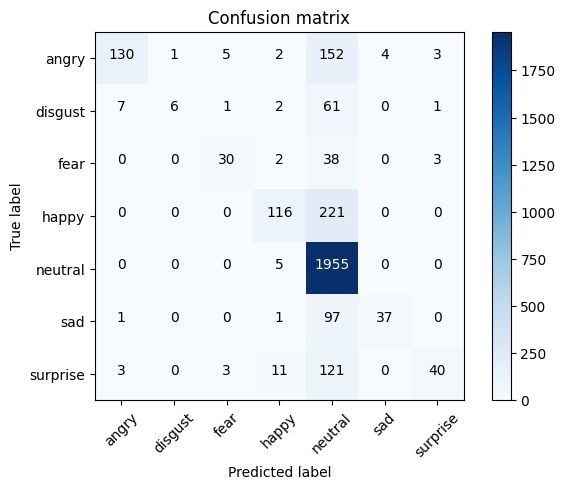

In [ ]:
emo_keys = list(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

print('Test Set Accuracy =  {0:.4f}'.format(accuracy_score(emotion_label, y_pred_optuna)))
print('Test Set F-score =  {0:.4f}'.format(f1_score(emotion_label, y_pred_optuna, average='macro')))
print('Test Set Precision =  {0:.4f}'.format(precision_score(emotion_label, y_pred_optuna, average='macro')))
print('Test Set Recall =  {0:.4f}'.format(recall_score(emotion_label, y_pred_optuna, average='macro')))

plot_confusion_matrix(confusion_matrix(emotion_label, y_pred_optuna), classes=emo_keys)

[array([[ 190,    2,    1,    3,   84,    6,   10],
        [  20,   13,    1,    1,   40,    1,    2],
        [   8,    0,   49,    4,    8,    1,    4],
        [   9,    2,    1,  185,  134,    2,    4],
        [  54,    9,   10,   42, 1777,   34,   34],
        [   3,    0,    0,    1,   15,  117,    1],
        [   7,    0,    9,    6,   43,    2,  111]]),
 array([[ 213,    7,    3,    2,   58,    5,    9],
        [  21,   36,    2,    2,   16,    0,    1],
        [   7,    0,   51,    2,    5,    3,    6],
        [   6,    4,    2,  230,   80,    3,   12],
        [ 182,   66,   15,  103, 1510,   40,   44],
        [   3,    0,    0,    0,   23,  110,    0],
        [  14,    1,   10,    9,   39,    0,  105]]),
 array([[ 180,    5,    3,    2,   97,    3,    7],
        [   9,   25,    6,    1,   33,    0,    4],
        [   7,    0,   49,    2,    7,    2,    6],
        [   7,    0,    5,  162,  149,    1,   12],
        [  17,    0,    5,   59, 1864,    7,    8],
        